In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:

def beamspace_channel(M, K, L, angle=0):
    """M 天线数   K 用户数   L 路径数"""

    m = np.arange(M)
    fai_m = 1 / M * (m - (M ) / 2);

    '''傅里叶变换矩阵'''
    U = []
    for i in range(M):
        U.append(1/math.sqrt(M)*np.exp(-1j*2*np.pi*fai_m[i]*m))

    U = np.array(U)
    U = U.conjugate()

    G = []
    for k in range(K):
        #Los_gain = (1+np.random.randn(1)*0.5)*np.exp(1j*np.random.rand(1)*2*np.pi) 
        #距离默认是100  pathloss增加了10^10 不然太小
        # Los_loss = 61.4 + 20*2 + np.random.randn(1)*math.pow(10,0.58)
        # Los_loss = math.pow(10, (100-Los_loss)/10)
        # Los_gain = Los_gain*Los_loss
        Los_gain = np.random.randn(1) + 1j*np.random.randn(1)
        #Los_gain = (1 + np.random.randn(1) * 0.2) * np.exp(1j * np.random.rand(1) * 2 * np.pi)
        theta =  2*np.pi * np.random.rand(1)+np.pi/2
        #固定角度
        #theta = np.pi * k / K+np.pi/2#+np.random.randn(1)*1/K*np.pi+angle
        fai = np.sin(theta)/2
        fai = (np.random.rand(1)-0.5)#*1/K +k/K
        g =  Los_gain*1/math.sqrt(M)*np.exp(-1j*2*np.pi*fai*m);
        for l in range(L-1):
            # nLos_gain = np.random.randn(1) + 1j * np.random.randn(1)
            # nLos_loss = 72 + 29.2 * 2 + np.random.randn(1) * math.pow(10, 0.87)
            # nLos_loss = math.pow(10, (100 - nLos_loss) / 10)
            # nLos_gain = nLos_gain * nLos_loss
            nLos_gain = np.sqrt(0.2)*(np.random.randn(1) + 1j*np.random.randn(1))
            theta = 2 * np.pi * np.random.rand(1)
            fai = np.sin(theta) / 2
            fai = np.random.rand(1)-0.5
            g = g + nLos_gain * 1 / math.sqrt(M) * np.exp(-1j * 2 * np.pi * fai * m);
        G.append(g)
    G = np.array(G)
    H = np.dot(U,G.T)


    """画出每个beam的能量"""
    beam_energy = np.sum(np.abs(H),1)
    # print(beam_energy)
    plt.plot(m,beam_energy)
    plt.show()

    return  H

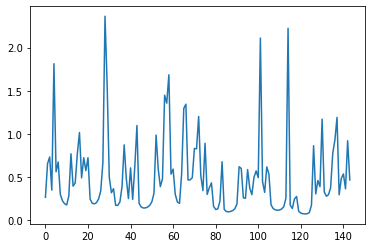

In [4]:
H_beam = beamspace_channel(M=144, K=4, L=16)

# Extension of S-V channel model
* ref: https://blog.csdn.net/qq_23947237/article/details/89925088
    * https://blog.csdn.net/qq_39227541/article/details/119358373
* Base station is at (0,0,height)
* coordinates of cluster center will be generated randomly
* N_ray Scatter will be generated randomly around cluster center
* each scatter will create an NLOS path with a random complex parameter beta
* there will be a LOS path directly from transmitter & receiver

<center class = "half">
<img src="./pics/defi.jpg" style="zoom:27%;"/>
<img src="./pics/defi1.jpg" style="zoom:33%;"/>
</center>

In [4]:
'''
Author: dhy
Mail: git config user.email
Date: 2022-11-22 10:56:58
LastEditors: dhy
LastEditTime: 2022-11-24 06:56:01
FilePath: /PyMIMO/test.ipynb
Description: 

Copyright (c) 2022 by dhy 3057931787@qq.com, All Rights Reserved. 
'''
class Pos():
    def __init__(self, x , y, z) -> None:
        self.x = x
        self.y = y
        self.z = z
    def vector(self,):
        return np.array([self.x,self.y,self.z])
        
class UPA():
    def __init__(self, H_ant_num, V_ant_num, bearing = 0*np.pi, downtilt = 0*np.pi, slant = 0*np.pi) -> None:
        # The angle alpha is called the bearing angle, beta is called the downtilt angle and gamma is called the slant angle.
        self.H_ant_num = H_ant_num
        self.V_ant_num = V_ant_num
        self.bearing =  bearing
        self.downtilt = downtilt
        self.slant = slant

    def get_array_response(self, G_azimuth, G_elevation):
        # H_angle V_angle are from LCS
        # antenna lies in local zOy plane
        L_azimuth, L_elevation = self.Angle_From_GCS_to_LCS(G_azimuth, G_elevation)
        vector_V = np.exp(1j * np.arange(start=0, stop=self.V_ant_num , step=1, dtype=np.complex128) * np.pi * np.cos(L_elevation))
        vector_H = np.exp(1j * np.arange(start=0, stop=self.H_ant_num , step=1, dtype=np.complex128) * np.pi *np.sin(L_azimuth) * np.sin(L_elevation))
        beams = np.kron(vector_V,vector_H)
        y = beams/np.sqrt(self.H_ant_num *self.V_ant_num )
        return y

    def Coordinate_From_GCS_to_LCS(self, G_pos : Pos):
        R_z = np.array([[np.cos(self.bearing), -np.sin(self.bearing), 0],[np.sin(self.bearing), np.cos(self.bearing), 0],[0, 0, 1]])
        R_y = np.array([[np.cos(self.downtilt), 0, np.sin(self.downtilt)],[0,1,0],[-np.sin(self.downtilt), 0, np.cos(self.downtilt)]])
        R_x = np.array([[1,0,0],[0,np.cos(self.slant),-np.sin(self.slant)],[0,np.sin(self.slant),np.cos(self.slant)]])
        R = R_z@R_y@R_x
        R_reverse = R.T
        Lvec = R_reverse @ G_pos.vector()
        Lpos = Pos(Lvec[0],Lvec[1],Lvec[2]) 
        return Lpos

    def Cal_angel_from_coordinate(self, pos : Pos):
        x,y,z = pos.x, pos.y, pos.z
        if x == 0 and y == 0 and z == 0:
            raise ValueError("Cannot derive angle from O")
        d = np.sqrt(x^2 + y^2 + z^2)
        x = x/d
        y = y/d
        z = z/d
        L_elevation = np.arccos(z)
        L_azimuth = np.arctan(y/x)
        return L_azimuth, L_elevation


    def Angle_From_GCS_to_LCS(self, azimuth, elevation):
        # unit vector coordinates of the path 
        x_G = np.sin(elevation) * np.cos(azimuth)
        y_G = np.sin(elevation) * np.sin(azimuth)
        z_G = np.cos(elevation)
        G_pos = Pos(x_G,y_G,z_G)
        Lpos = self.Coordinate_From_GCS_to_LCS(G_pos)
        L_azimuth, L_elevation = self.Cal_angel_from_coordinate(Lpos)
        return L_azimuth, L_elevation
        # 


<center class = "half">
<img src="./pics/lcs_gcs.jpg" style="zoom:80%;"/>
</center>

In [ ]:

class Transmitter():
    def __init__(self, H_ant_num, V_ant_num, N_s, pos : Pos = None) -> None:
        self.pos = pos
        self.array = UPA(H_ant_num, V_ant_num)
        self.Nt_H = H_ant_num
        self.Nt_V = V_ant_num
        self.N_s = N_s
    def get_position(self,):
        return self.pos

        
class Receiver():
    def __init__(self, H_ant_num, V_ant_num, pos=None) -> None:
        self.array = UPA(H_ant_num, V_ant_num)
        self.Nt_H = H_ant_num
        self.Nt_V = V_ant_num


In [ ]:
class SubPath():
    def __init__(self, scatter_pos : Pos, start : Pos, end : Pos) -> None:
        self.scatter_pos = scatter_pos
        self.start = start
        self.end = end
        # TODO: calculate AOD(h,v) AOA(h,v)
    def get_angles():
        

class Cluster():
    def __init__(self, center : Pos = Pos(5,5,5), scatter_std : float = 1.0) -> None:
        pass


class Channel():
    def __init__(self, tx : Transmitter, rx : Receiver, \
                 N_cluster : int, N_ray : int, realization : int) -> None:
        self.N_sub_path = int(N_cluster*N_ray)
        self.Nt = tx.Nt_H*tx.Nt_V
        self.Nr = rx.Nt_H*rx.Nt_V
        # initialize arrays
        self.AoA = np.zeros((2, N_cluster*N_ray))
        self.AoD = np.zeros((2, N_cluster*N_ray))
        self.H = np.zeros((Nr,Nt,realization),dtype=np.complex64)
        self.At = np.zeros((Nt,N_cluster*N_ray,realization),dtype=np.complex64)
        self.Ar = np.zeros((Nr,N_cluster*N_ray,realization),dtype=np.complex64)
        self.alpha = np.zeros((N_cluster*N_ray,realization),dtype=np.complex64)
        self.Fopt =  np.zeros((Nt,tx.N_s,realization),dtype=np.complex64)
        self.Wopt =  np.zeros((Nr,tx.N_s,realization),dtype=np.complex64)
        # simulation params
        angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx
        gamma = np.sqrt((tx.Nt_H*tx.Nt_V*rx.Nt_H*rx.Nt_V)/(N_cluster*N_ray)) # normalization factor
        sigma = 1 # according to the normalization condition of the H
        count = 0
        for reali in range(realization):
            # generate AoA/AoD data for each cluster
            for c in range(Nc):
                AoD_m = np.random.uniform(0,2*np.pi,size=(1,2))
                AoA_m = np.random.uniform(0,2*np.pi,size=(1,2))
                # Note: should divide angle_sigma by sqrt 2 to adopt numpy.random.laplace api
                # AoA/AoD is from a laplace distribution of mean m and std angle_sigma
                AoD[0,c*Nray:Nray*(c+1)] = AoD_m[:,0] + np.random.laplace(loc=AoD_m[:,0],scale=angle_sigma/np.sqrt(2),size=(1,Nray)) 
                AoD[1,c*Nray:Nray*(c+1)] = AoD_m[:,1] + np.random.laplace(loc=AoD_m[:,1],scale=angle_sigma/np.sqrt(2),size=(1,Nray)) 
                AoA[0,c*Nray:Nray*(c+1)] = AoA_m[:,0] + np.random.laplace(loc=AoA_m[:,0],scale=angle_sigma/np.sqrt(2),size=(1,Nray)) 
                AoA[1,c*Nray:Nray*(c+1)] = AoA_m[:,1] + np.random.laplace(loc=AoA_m[:,1],scale=angle_sigma/np.sqrt(2),size=(1,Nray)) 
            
            # calculate H
            for j in range(0,N_sub_path):
                At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt_H,Nt_V) # UPA array response
                Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr_H,Nr_V)
                alpha[j,reali] = np.random.normal(0,np.sqrt(sigma/2)) + 1j*np.random.normal(0,np.sqrt(sigma/2))
                H[:,:,reali] = H[:,:,reali] + alpha[j,reali] * np.expand_dims(Ar[:,j,reali],axis=-1) @ np.expand_dims(np.conjugate(At[:,j,reali].T),axis=0)

            H[:,:,reali] = gamma * H[:,:,reali]
            
            if(np.linalg.matrix_rank(H[:,:,reali])>=Ns):
                count = count + 1
                [U,S,V] = np.linalg.svd(H[:,:,reali],full_matrices=True)
                Fopt[:,:,reali] = V[0:Nt,0:Ns]
                Wopt[:,:,reali] = U[0:Nr,0:Ns]
   

